### **3. 提出的方法**

#### **3.1. 总体框架**

在本文中，我们关注一般情境下的多模态学习中的缺失模态问题。我们假设存在几种缺失模态的情况，例如，缺失一个模态或缺失多个模态，以代表现实世界中多模态学习的更真实场景。注意，训练期间的缺失情况也可能与测试期间的不同。此外，由于预训练的转换器变得越来越大，且受限于计算资源而无法训练，因此，开发一种无需微调整个预训练模型的方法至关重要。

**问题定义**。为了尽可能简单但不失一般性，我们考虑一个由 $M=2$ 个模态 $m_1$ 和 $m_2$（例如，图像和文本）组成的多模态数据集。给定一个多模态数据集 $D=\{D^c,D^{m_1},D^{m_2}\}$，我们将 $D^c=\{x_i^{m_1},x_i^{m_2},y_i\}$ 表示为模态完整的子集，而 $D^{m_1}=\{x_j^{m_1},y_j\}$ 和 $D^{m_2}=\{x_k^{m_2},y_k\}$ 分别表示模态不完整的子集（例如，仅文本和仅图像），其中缺失了一个模态。如图 $\color{red}2$ 所示，训练数据可能包含具有不同缺失情况的数据样本，包括完整数据 $D^c$、仅文本数据 $D^{m_1}$ 和仅图像数据 $D^{m_2}$。

为了保留多模态输入的格式，我们简单地为缺失模态的数据分配虚拟输入 $\tilde{x}^{m_1},\tilde{x}^{m_2}$（例如，文本/图像的空字符串/像素），并得到 $\tilde{D}^{m_1}=\{x_j^{m_1},\tilde{x}_j^{m_2},y_j\},\tilde{D}^{m_2}=\{\tilde{x}^{m_1},x_k^{m_2},y_k\}$。因此，带有缺失模态的多模态数据可以重构为 $\tilde{D}=\{D^c,\tilde{D}^{m_1},\tilde{D}^{m_2}\}$。

为了简单起见，我们遵循 [22] 并采用在大规模视觉和语言数据集上预训练的多模态转换器 ViLT [13] 作为我们的骨干模型。注意，由于计算资源的限制，骨干模型在我们的情境下是不可训练的。为了解决缺失模态问题，我们提出了缺失感知提示，以根据不同的输入情况指示预训练模型的预测。这些提示根据输入数据的缺失情况进行分配，并附加到多模态转换器的多个块中。在假设预训练模型不可训练的情况下，唯一可训练的参数是缺失感知提示、池化层和用于学习多模态分类器的全连接层。



#### **3.2. 为缺失模态设计的提示学习**

基于提示的学习最初作为自然语言处理（NLP）中的一种高效方法出现，用于在不微调整个预训练模型的情况下进行迁移学习。通常，提示被添加到输入中以指示模型预测。基于类似的动机，我们提出了缺失感知提示，以根据缺失模态的不同输入情况来指示预训练转换器。为此，我们为每个缺失模态情况设计了相应的缺失感知提示。如图2所示，我们首先为 $M$ 个模态任务分配 $\tilde{M^2}-1$ 个提示（例如，为视觉-语言任务分配3个缺失感知提示），并根据缺失模态的类型将它们添加到输入中。

给定一个具有 $N$ 个连续MSA（多头自注意力）层的预训练多模态转换器 $f_\mathrm{\theta}$，我们将第 $i$ 个MSA层的输入嵌入特征表示为 $h^i\in\mathbb{R}^{L\times d}$，其中 $i=1,2,...,\bar{N}$，输入长度为 $L$，嵌入维度为 $d$。注意，$h^1$ 是模态特定嵌入函数的输出，这些函数将输入预处理为标记序列（即，文本模态的BERT标记器和图像模态的视觉嵌入 [6] 层）。然后，缺失感知提示 $p_m^i\in\mathbb{R}^{L_p\times d}$ 被附加到第 $i$ 层，其中 $L_p$ 是提示长度，$d$ 是嵌入维度，$m\in\{c,m_1,m_2\}$ 表示不同的缺失模态情况。最后，缺失感知提示被附加到嵌入特征上，沿着输入长度维度形成扩展特征 $h_p^i$：

（1）

$$h_p^i=f_{prompt}(p_m^i,h^i),$$


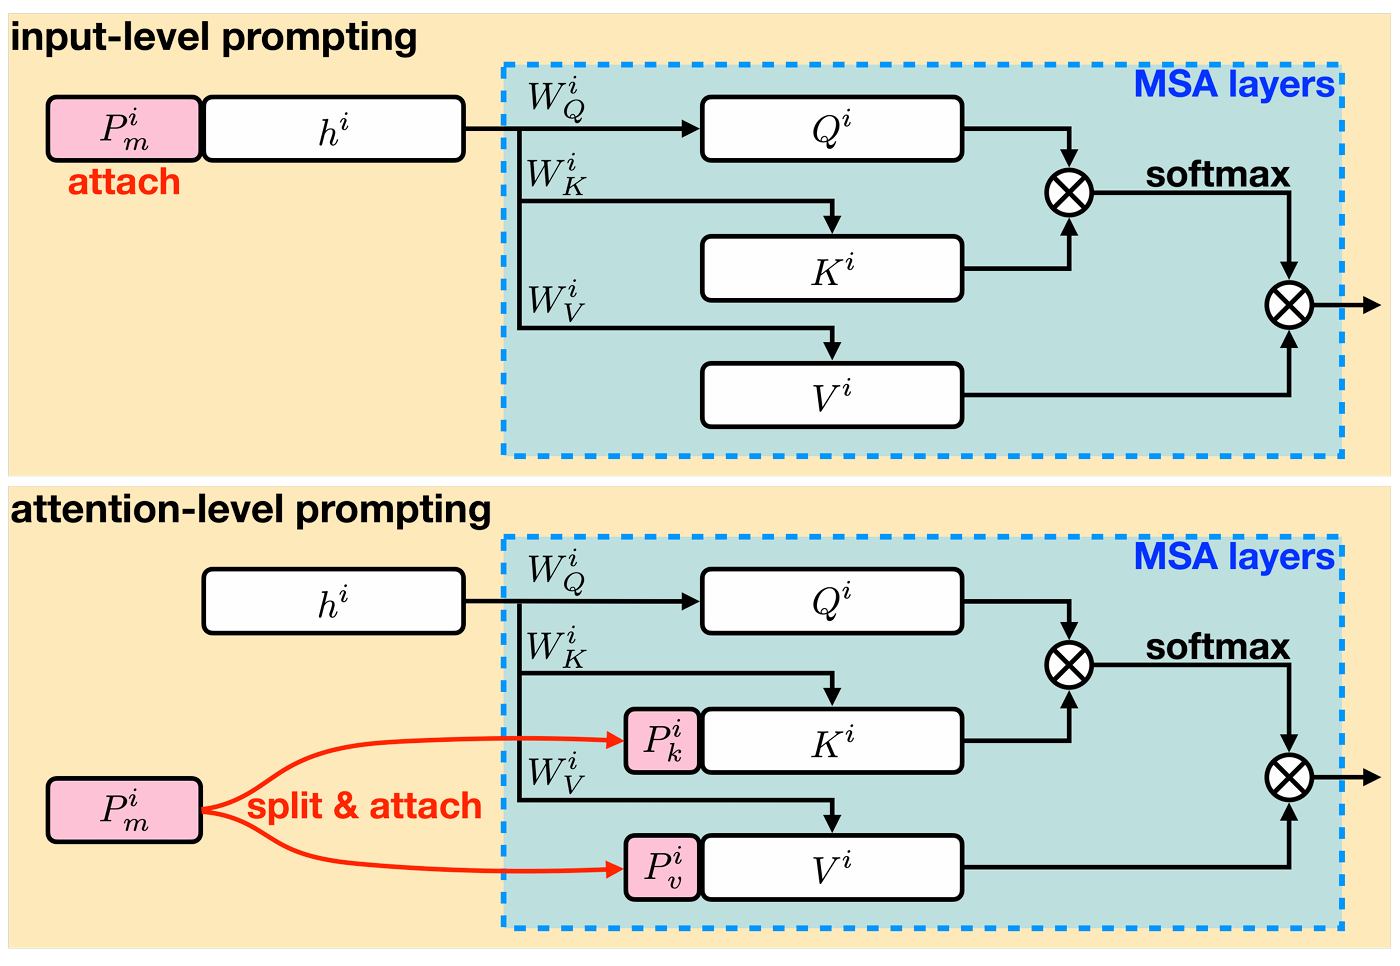

---

**图3**. 两种提示方法的说明。顶部块显示了输入级提示方法，它将缺失感知提示 $p_m^i$ 附加到第 $i$ 个MSA层的输入。底部块显示了注意力级提示方法，它首先将缺失感知提示 $p_m^i$ 拆分为两个子提示 $p_k^i,p_v^i$，长度相同，并将它们分别附加到第 $i$ 个MSA层中的键 $K^i$ 和值 $V^i$（见第3.3节）。

---

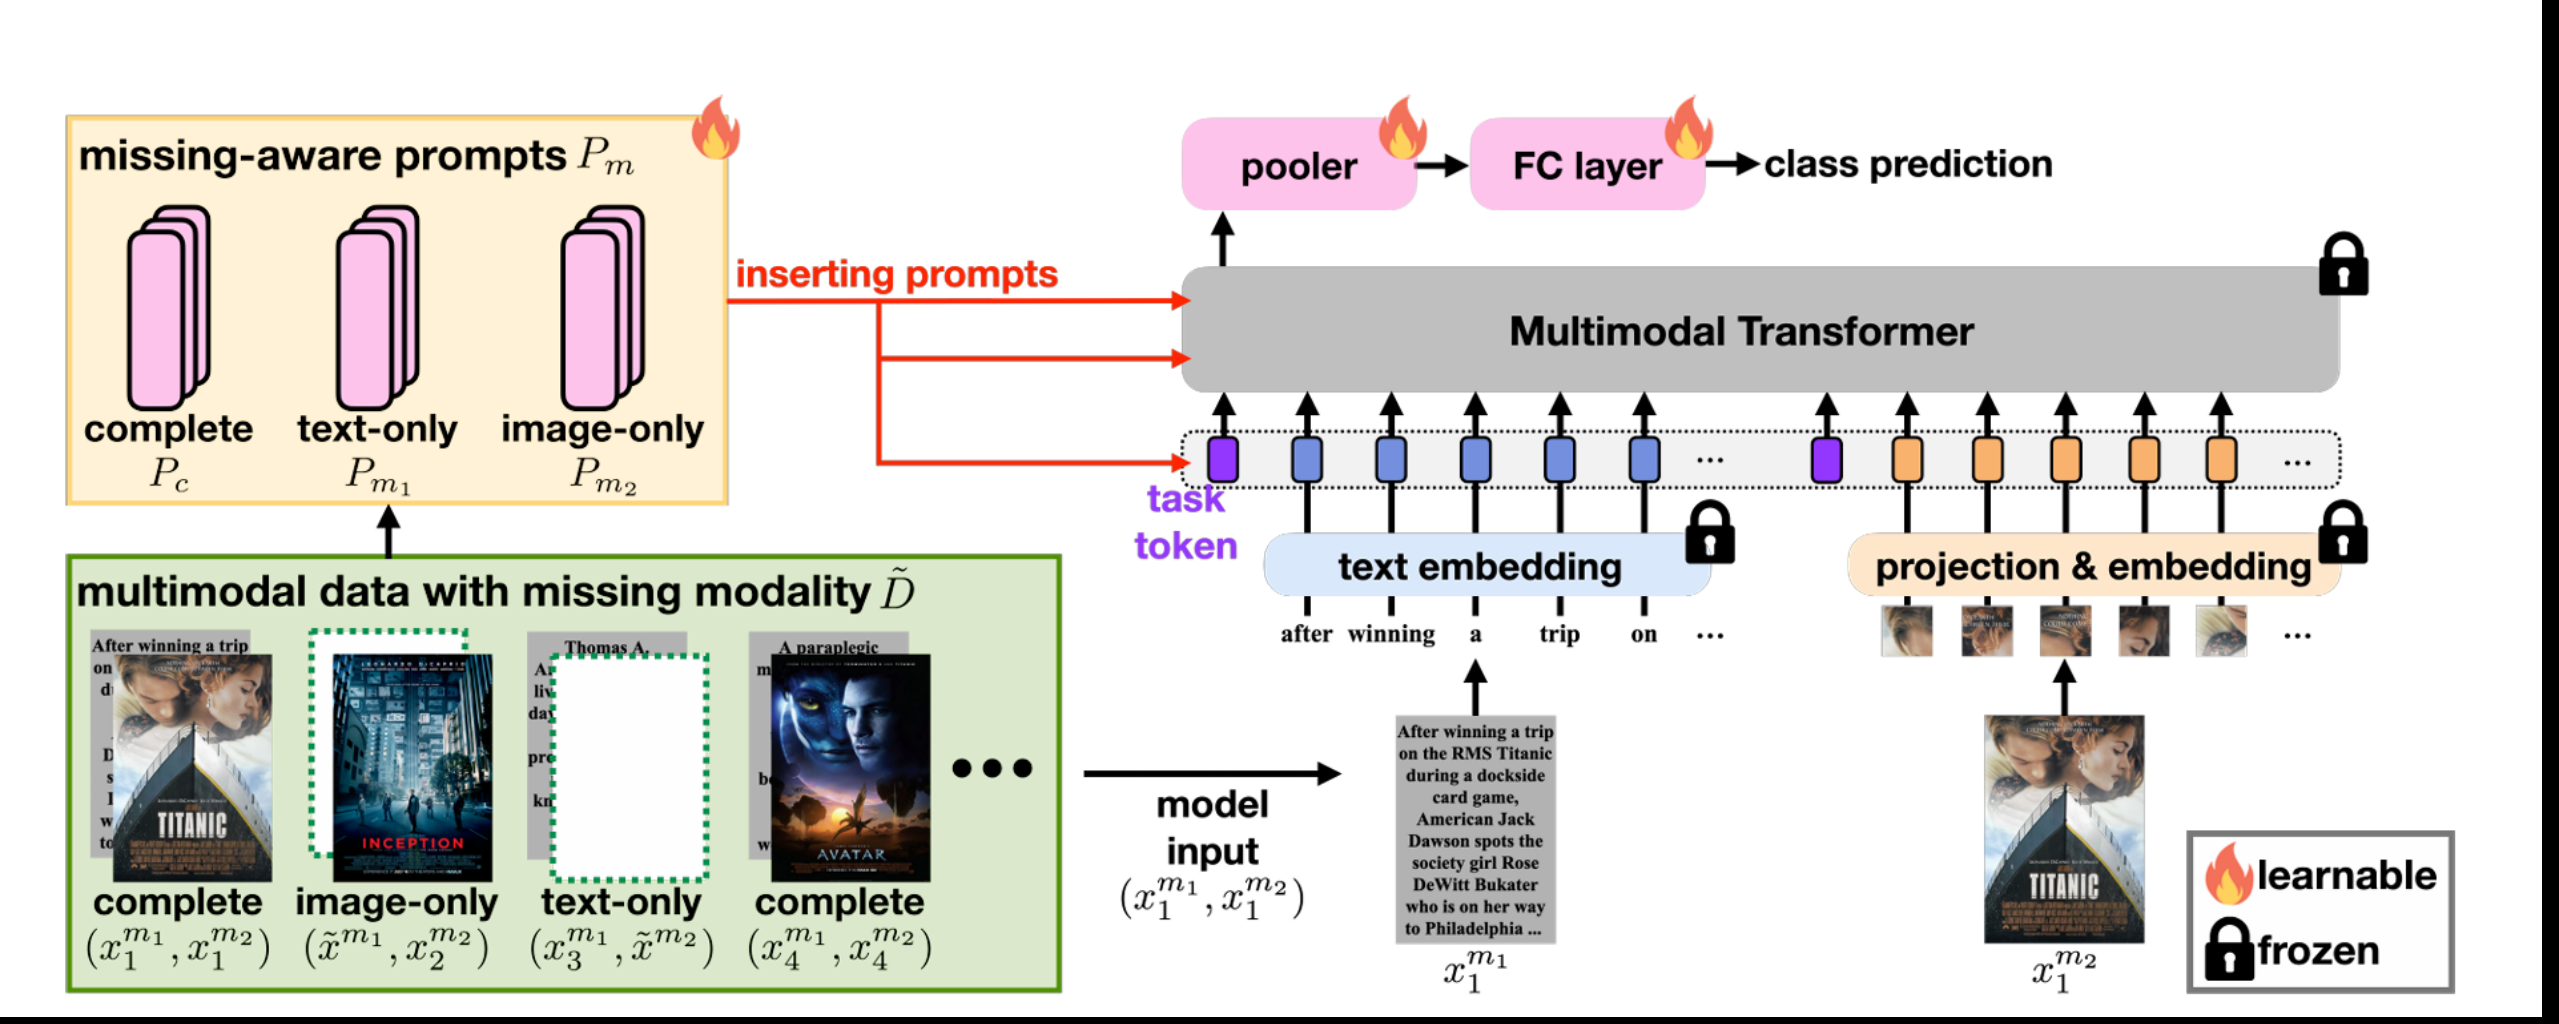

---

**图2**. 我们提出的基于提示的多模态框架概述。我们首先根据多模态输入 $(x_i^{\tilde{m}_1},x_i^{\tilde{m}_2})$ 的缺失情况（例如，在视觉-语言任务中的完整、仅文本、仅图像）选择缺失感知提示 $P_m$，其中虚拟输入 $\{\tilde{x}^{m_1},\tilde{x}^{m_2}\}$ 分别用于文本和图像的缺失模态。然后，我们通过不同的提示方法（见图3和第3.3节）将缺失感知提示附加到多个MSA层中。我们选择与文本相关的任务标记作为最终输出特征，并将它们输入到池化层和全连接（FC）层进行类别预测。注意，只有粉红色阴影块需要训练，而其他部分是冻结的。

---



其中，$f_{prompt}$ 定义了将提示附加到嵌入特征的方法，将在下一节中详细介绍。**总体目标**。对于模型训练，我们冻结多模态转换器的所有参数 $f_\theta$，除了任务特定的层 $f_{\theta_t}$（即，池化层和全连接层），以便根据每个视觉感知任务输出相应的预测。此外，我们将 $\theta_p$ 表示为缺失感知提示的参数。具有可训练参数的总体目标定义为：

$$L=L_{task}(x_i^{m_1},x_i^{m_2};\theta_t,\theta_p),$$

（2）

其中，$(x_i^{m_1},x_i^{m_2})\in\tilde{D}$ 是具有缺失模态情况的多模态输入对，$L_{task}$ 表示任务特定的多模态目标，例如，用于电影类型分类的二元交叉熵损失。



### **3.3. 提示设计**

在本节中，我们重点关注设计 $f_{prompt}$ 函数，该函数将提示附加到每个输入层，如（1）所示。通常，大多数基于提示的方法会将提示添加到输入序列中，并指导模型进行下游任务。然而，[36] 表明提示的配置和提示添加的位置对基于提示的学习至关重要。在我们的情况下，由于输入模态可能缺失，研究附加提示的适当配置非常重要。在图3中，我们介绍了两种提示配置：**输入级提示和注意力级提示**。

**输入级提示**。一种常见的附加提示的方法是将提示添加到每个层的输入序列中，如图3顶部所示。提示函数可以表示为：

$$f_{prompt}^{input}(p_m^i,h^i)=[p_m^i;h^i],$$

（3）

其中，$[\cdots;\cdots]$ 表示连接操作。假设有 $N_p$ 层附加提示参数，每个MSA层的输入/输出序列的长度会随着层数的增加而变大。例如，带有提示的最后一个MSA层的输出序列的长度将变为 $(N_pL_p+L)$。通过这种方式，当前层的提示可以与继承自前几层的提示标记进行交互，从而为模型预测学习更有效的指令。然而，我们发现这种输入序列长度的增加使输入级提示学习对具有不同多模态标记长度的数据集敏感，这可能对某些多模态下游任务不太有利。我们在第4.2节中讨论了细节。

**注意力级提示**。另一种提示方法是使用提示修改MSA层的输入 [33]。在图3的底部，我们将提示拆分为两个子提示 $p_k^i,p_v^i$，具有相同的序列长度 $\frac{L_p}{2}$，并将它们分别添加到键和值向量中。我们将MSA层的查询、键和值表示为：
$$Q^i=h^iW_Q^i;K^i=h^iW_K^i;V^i=h^iW_V^i,$$
（4）
其中，$W_Q^i,W_K^i,W_V^i\in\mathbb{R}^{d\times d}$ 是MSA层的投影权重。然后，我们可以将注意力级提示的提示函数 $f_{prompt}$ 定义为：

（5）

$$\begin{aligned}&f_{prompt}^{attn}(p_{m}^{i},h^{i})=\mathrm{ATTENTION}^{i}(p_{m}^{i},h^{i}),\\&\mathrm{ATTENTION}^{i}=\text{softmax}\left(\frac{Q^{i}[p_{k}^{i},K^{i}]^{T}}{\sqrt{d}}\right)[p_{v}^{i};V^{i}].\end{aligned}$$

注意力级提示提供了另一种从转换器中注意力机制的角度指导预训练模型的方法。由于提示没有添加到查询向量中，输出序列的长度与输入序列相同。

**多层提示和提示附加的位置**。直观地，多模态转换器的不同层具有不同的特征嵌入上下文 [28]，每层提示的效果可能不同。通过自注意力机制，来自不同模态的输入标记在转换器层中紧密融合。也就是说，与任务目标相关联的、与多模态标记良好融合的较深层相比，早期层的特征可能具有更多来自不同模态的特征。这促使我们探索附加缺失感知提示的最适当位置。

这里，我们介绍了提示的多层扩展，可以表示为 $P_m=\{p_m^i\}_{i=start}^{end}\in\mathbb{R}^{N_p\times L_p\times d}$，其中 $p_m^i$ 是附加到转换器中第 $i$ 层输入序列（输入级）或MSA层（注意力级）的提示，$N_p=(end-start+1)$ 是带有提示的总层数。注意，我们简单地假设所选MSA层的索引是连续的。与将提示附加到所有层或仅第一层不同，我们经验性地发现，从第一层开始的前一半层是最佳位置 $(start=0,end=\frac{N}{2}-1)$，其中 $N_p=\frac{N}{2}$。更多结果和讨论在第4.3节中。